## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , MinMaxScaler , StandardScaler , LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , accuracy_score
from sklearn.utils import resample

## A. Read the dataset

In [2]:
df = pd.read_csv(r"heart.csv")

## B. Display first 5 rows from dataset

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## C. Shape of your dataset

In [4]:
print( "Rows and Columns" , df.shape)

Rows and Columns (918, 12)


## D. Information about dataset

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


## 2: Perform all preprocessing steps needed.

## A. Missing Values

In [6]:
# make missing value in my dataset
def make_null(df):
    np.random.seed(1)  
    percentage_null = 0.2
    num_nulls = int(len(df) * percentage_null)
    indices = np.random.choice(df.index, size=num_nulls, replace=False)
    df.loc[indices, 'Cholesterol'] = np.nan
    return df
df = make_null(df) 

print(df.isnull().sum()) 
print("#######################################") 

# Handling the missing values
def handling_missing_Value(df):   
    medication_dict = {}
    for medication_name,frame_name in df.groupby('ChestPainType'):
        Q1=df['Cholesterol'].quantile(.25)
        Q3=df['Cholesterol'].quantile(.75)
        IQR=Q3-Q1
        lower_bound=Q1-1.5*IQR
        upper_bound=Q3+1.5*IQR
        filtered_age=df.loc[(df['Cholesterol'] <=upper_bound)&((df['Cholesterol'] >=lower_bound)),'Cholesterol']
        medication_dict[medication_name]=filtered_age.mean()

    df['Cholesterol']=df['Cholesterol'].fillna(df['ChestPainType'].map(medication_dict))  
    return df

df = handling_missing_Value(df)
print(df.isnull().sum())

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       183
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64
#######################################
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


## B. Drop Duplicated values

In [7]:
df = df.drop_duplicates() 
print("Number of Duplicated is: ",df.duplicated().sum())

Number of Duplicated is:  0


## C. Encoding Catogrical Data To Numerical 

In [8]:
 
#use LabelEncoder
label_encoder_sex = LabelEncoder()
label_encoder_exercise_angina = LabelEncoder() 
df['Sex'] = label_encoder_sex.fit_transform(df['Sex'])
df['ExerciseAngina'] = label_encoder_exercise_angina.fit_transform(df['ExerciseAngina'])

# use One-Hot-Encoding
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['ST_Slope', 'ChestPainType', 'RestingECG'])],remainder='passthrough')
df_encoded = ct.fit_transform(df)
encoded_df = pd.DataFrame(df_encoded, columns=ct.get_feature_names_out()) 
df = encoded_df
df.head()

#order columns original fisrt then encoded
remainder_columns = [col for col in df.columns if col.startswith('remainder__')]
encoder_columns = [col for col in df.columns if col.startswith('encoder__')]
new_order = remainder_columns + encoder_columns
df = df[new_order]
df.columns = [col.replace('remainder__', '') for col in remainder_columns] + [col.replace('encoder__', '') for col in encoder_columns]  # delet prefix
columns = list(df.columns) 
columns.remove('HeartDisease') 
columns.append('HeartDisease') 
df = df[columns]
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,HeartDisease
0,40.0,1.0,140.0,289.000000,0.0,172.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,49.0,0.0,160.0,180.000000,0.0,156.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,37.0,1.0,130.0,240.763699,0.0,98.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,48.0,0.0,138.0,240.763699,0.0,108.0,1.0,1.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,54.0,1.0,150.0,195.000000,0.0,122.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## D. Split (Train & Test)

In [9]:
X = df.iloc[: , :-1].values
y = df.iloc[: , -1].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 


## E. Outlier Handling (IQR)

In [10]:

bounds = []

for col in range(X_train.shape[1]):
    Q1 = np.percentile(X_train[:, col], 25)
    Q3 = np.percentile(X_train[:, col], 75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    bounds.append((lower, upper))

    X_train[:, col] = np.clip(X_train[:, col], lower, upper)

for col in range(X_test.shape[1]):
    lower, upper = bounds[col]
    X_test[:, col] = np.clip(X_test[:, col], lower, upper)


## F. Balancing 

Class 0.0: 333 samples
Class 1.0: 401 samples
Class 0.0: 45.37%
Class 1.0: 54.63%


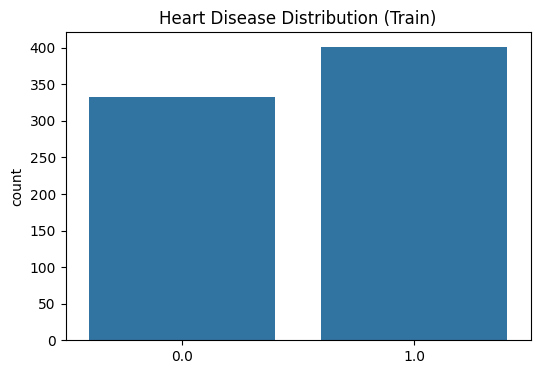

Before Balancing:
Class 0.0: 333 (45.37%)
Class 1.0: 401 (54.63%)

After SMOTE:
Class 0.0: 401 (50.00%)
Class 1.0: 401 (50.00%)


e:\Bi-Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\Bi-Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "e:\Bi-Project\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "C:\Users\NoobMaster69\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\NoobMaster69\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._

In [11]:
values, counts = np.unique(y_train, return_counts=True)

for v, c in zip(values, counts):
    print(f"Class {v}: {c} samples")

total = len(y_train)
for v, c in zip(values, counts):
    print(f"Class {v}: {c/total*100:.2f}%")

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Heart Disease Distribution (Train)")
plt.show()

#Balancing by SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_smote , y_train_smote = smote.fit_resample(X_train , y_train)

print("Before Balancing:")
values, counts = np.unique(y_train, return_counts=True)
for v, c in zip(values, counts):
    print(f"Class {v}: {c} ({c/len(y_train)*100:.2f}%)")
    
print("\nAfter SMOTE:")
values, counts = np.unique(y_train_smote, return_counts=True)
for v, c in zip(values, counts):
    print(f"Class {v}: {c} ({c/len(y_train_smote)*100:.2f}%)")

## G. Scaling

In [12]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.mean(axis=0))    
print(X_train_scaled.std(axis=0))     



[-1.87255600e-16  0.00000000e+00 -6.91544914e-16 -7.30569102e-15
  0.00000000e+00 -3.13706070e-16  1.27055496e-17 -6.71579050e-17
  0.00000000e+00 -2.45186856e-16  4.59819890e-17 -1.14954973e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.52144657e-16  0.00000000e+00]
[1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]


## 3: Train & test. 

## A. Training by (KNN , DT)

In [13]:
#DT
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

dt_model = DecisionTreeClassifier(max_depth=3,random_state=5)

dt_model.fit(X_train_scaled, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [14]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=21)

model.fit(X_train_scaled, y_train)    


,n_neighbors,21
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## B. Testing

In [15]:
y_pred = model.predict(X_test_scaled)
y_pred_dt = dt_model.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, confusion_matrix

print(" KNN \nAccuracy:", accuracy_score(y_test, y_pred)*100,"%") 
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


print("\nDecision Tree\nAccuracy:",accuracy_score(y_test, y_pred_dt)*100,"%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


 KNN 
Accuracy: 83.69565217391305 %
Confusion Matrix:
 [[70  7]
 [23 84]]

Decision Tree
Accuracy: 83.15217391304348 %
Confusion Matrix:
 [[72  5]
 [26 81]]


## 4: Predict the output of new values

## 5: visualizes the dataset after performing the model (predicted results VS. actual results). 

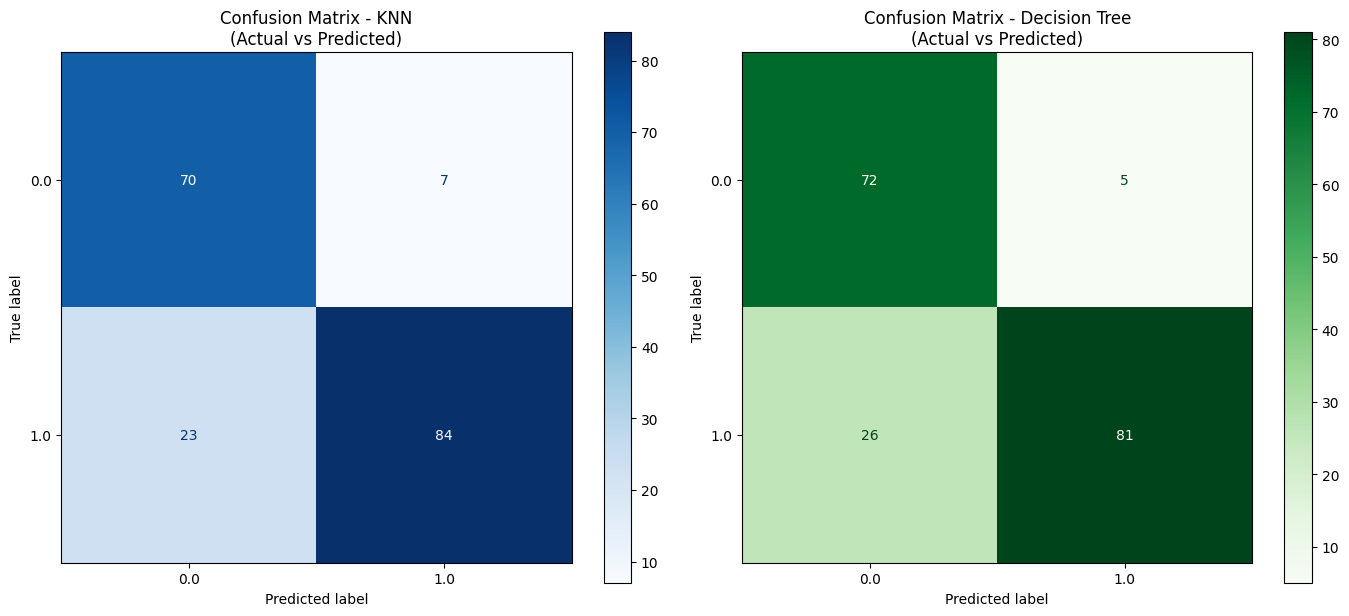

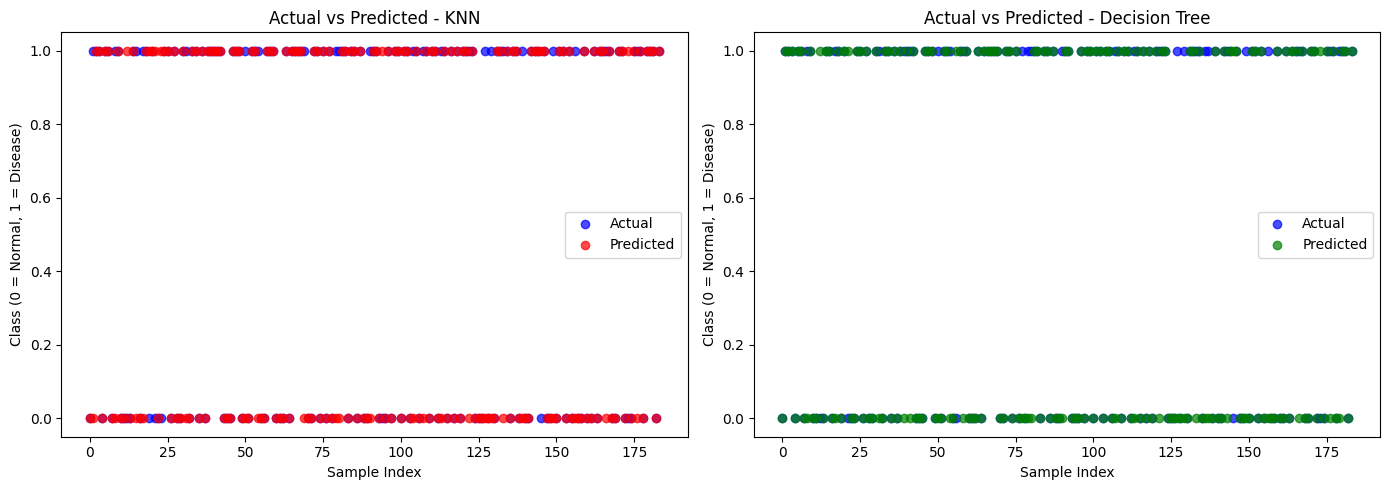

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Confusion Matrix for KNN
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap='Blues')
axes[0].set_title("Confusion Matrix - KNN\n(Actual vs Predicted)")

# Confusion Matrix for Decision Tree
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, ax=axes[1], cmap='Greens')
axes[1].set_title("Confusion Matrix - Decision Tree\n(Actual vs Predicted)")

plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
# Scatter for KNN
plt.subplot(1, 2, 1) 
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7, color='blue')
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.7, color='red')
plt.title("Actual vs Predicted - KNN")
plt.xlabel("Sample Index")
plt.ylabel("Class (0 = Normal, 1 = Disease)")
plt.legend()

# Scatter for Decision Tree
plt.subplot(1, 2, 2) 
plt.scatter(range(len(y_test)), y_test, label="Actual", alpha=0.7, color='blue')
plt.scatter(range(len(y_pred_dt)), y_pred_dt, label="Predicted", alpha=0.7, color='green') # غيرت اللون هنا عشان التمييز
plt.title("Actual vs Predicted - Decision Tree")
plt.xlabel("Sample Index")
plt.ylabel("Class (0 = Normal, 1 = Disease)")
plt.legend()

plt.tight_layout()
plt.show()



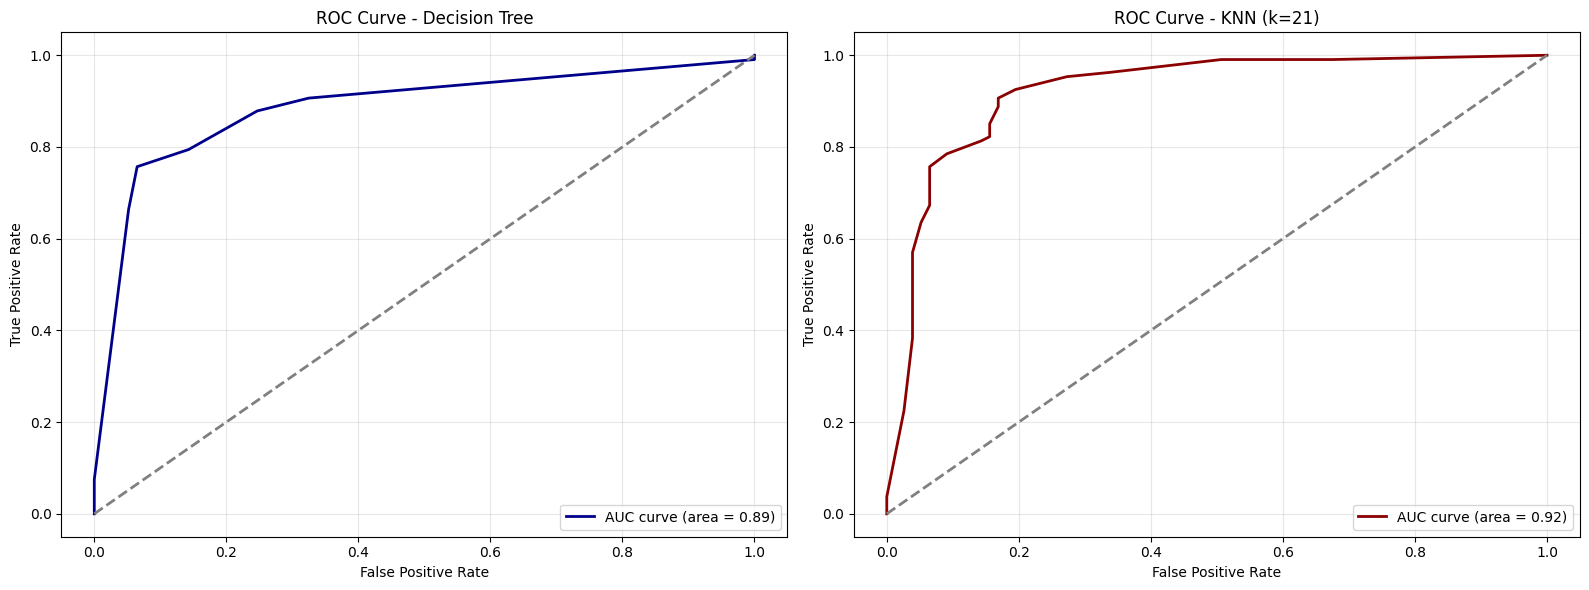

In [17]:
from sklearn.metrics import roc_curve, auc
y_prob_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
y_prob_knn = model.predict_proba(X_test_scaled)[:, 1]
plt.figure(figsize=(16, 6))

# ROC for DT
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, y_prob_dt)
dt_roc_auc = auc(dt_fpr, dt_tpr)

plt.subplot(1, 2, 1)
plt.plot(dt_fpr, dt_tpr, color='darkblue', lw=2, label=f'AUC curve (area = {dt_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# ROC for KNN
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, y_prob_knn)
knn_roc_auc = auc(knn_fpr, knn_tpr)

plt.subplot(1, 2, 2)
plt.plot(knn_fpr, knn_tpr, color='darkred', lw=2, label=f'AUC curve (area = {knn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - KNN (k={21})')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6: Evaluate model (Use confusion matrix , accuracy , Recall  , Precision  , F1 )

KNN MODEL (k=21)
Accuracy : 83.70 %
Confusion Matrix:
 [[70  7]
 [23 84]]
------------------------------
num of True Positive  (TP): 84
num of True Negative  (TN): 70
num of False Positive (FP): 7
num of False Negative (FN): 23


DECISION TREE MODEL 
Accuracy : 83.15 %
Confusion Matrix:
 [[72  5]
 [26 81]]
------------------------------
num of True Positive  (TP): 81
num of True Negative  (TN): 72
num of False Positive (FP): 5
num of False Negative (FN): 26

FINAL MODEL COMPARISON SUMMARY
  Model  Accuracy  Recall  Precision  F1 Score
0   KNN     83.70    78.5      92.31     84.85
1    DT     83.15    75.7      94.19     83.94
--------------------------------------------------


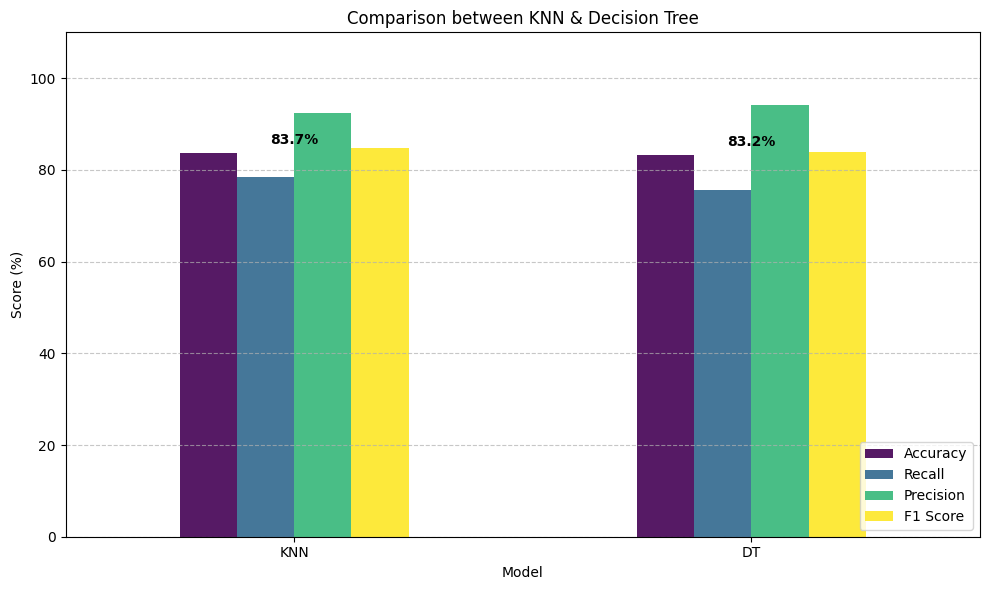

Best MODEL IS: K-Nearest Neighbors (KNN)


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. KNN Model Results
print("KNN MODEL (k=21)")

acc_knn = accuracy_score(y_test, y_pred)
cm_knn = confusion_matrix(y_test, y_pred)

print(f'Accuracy : {acc_knn*100:.2f} %')
print("Confusion Matrix:\n", cm_knn)
print("-" * 30)

print("num of True Positive  (TP):", cm_knn[1][1]) 
print("num of True Negative  (TN):", cm_knn[0][0])
print("num of False Positive (FP):", cm_knn[0][1])
print("num of False Negative (FN):", cm_knn[1][0])


# 2. Decision Tree Model Results
print("\n" + "="*40 +"\n")
print("DECISION TREE MODEL ")

acc_dt = accuracy_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print(f'Accuracy : {acc_dt*100:.2f} %')
print("Confusion Matrix:\n", cm_dt)
print("-" * 30)

print("num of True Positive  (TP):", cm_dt[1][1]) 
print("num of True Negative  (TN):", cm_dt[0][0])
print("num of False Positive (FP):", cm_dt[0][1])
print("num of False Negative (FN):", cm_dt[1][0])


# 3. KNN vs Decision Tree
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

models = ['KNN', 'DT']
predictions = [y_pred, y_pred_dt] 

accuracy_list = [accuracy_score(y_test, p) * 100 for p in predictions]
recall_list = [recall_score(y_test, p) * 100 for p in predictions]
precision_list = [precision_score(y_test, p) * 100 for p in predictions]
f1_list = [f1_score(y_test, p) * 100 for p in predictions]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_list,
    'Recall': recall_list,
    'Precision': precision_list,
    'F1 Score': f1_list
})

print("\n" + "="*40)
print("FINAL MODEL COMPARISON SUMMARY")
print(comparison_df.round(2))
print("-" * 50)

comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6), colormap='viridis', alpha=0.9)

plt.title('Comparison between KNN & Decision Tree')
plt.ylabel('Score (%)')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.ylim(0, 110)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, val in enumerate(comparison_df['Accuracy']):
    plt.text(i, val + 2, f"{val:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Best MODEL IS: K-Nearest Neighbors (KNN)")